In [1]:
from pyspark.sql import SparkSession


spark = (
    SparkSession.builder.master("local[*]")
    .appName("local_testing")
    .config("spark.driver.host", "127.0.0.1")
    .getOrCreate()
)

spark

23/12/03 16:49:34 WARN Utils: Your hostname, Salmans-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.68.74 instead (on interface en0)
23/12/03 16:49:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/03 16:49:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# STEP 1: Read in Advanced Stats CSV data and filter to only NBA data (removing historical ABA data)
adv_stats_file = "NBA_data/Advanced.csv"
# filter down to only NBA data
df_adv_stats = spark.read.csv(
    adv_stats_file, header=True, nullValue="NA", inferSchema=True
).where("lg = 'NBA'")
df_adv_stats.createOrReplaceTempView('tmp_raw_advanced_stats')
df_adv_stats.printSchema()
print(df_adv_stats.count())

23/12/03 16:49:44 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


root
 |-- seas_id: integer (nullable = true)
 |-- season: integer (nullable = true)
 |-- player_id: integer (nullable = true)
 |-- player: string (nullable = true)
 |-- birth_year: integer (nullable = true)
 |-- pos: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- experience: integer (nullable = true)
 |-- lg: string (nullable = true)
 |-- tm: string (nullable = true)
 |-- g: integer (nullable = true)
 |-- mp: integer (nullable = true)
 |-- per: double (nullable = true)
 |-- ts_percent: double (nullable = true)
 |-- x3p_ar: double (nullable = true)
 |-- f_tr: double (nullable = true)
 |-- orb_percent: double (nullable = true)
 |-- drb_percent: double (nullable = true)
 |-- trb_percent: double (nullable = true)
 |-- ast_percent: double (nullable = true)
 |-- stl_percent: double (nullable = true)
 |-- blk_percent: double (nullable = true)
 |-- tov_percent: double (nullable = true)
 |-- usg_percent: double (nullable = true)
 |-- ows: double (nullable = true)
 |-- dws: do

In [3]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import FloatType


@udf(returnType=FloatType())
def map_position(x: int):
    lookup = {
        "PG": 1,
        "G": 1.5,
        "SG": 2,
        "SF": 3,
        "F": 3.5,
        "PF": 4,
        "C": 5,
    }
    val_list = x.split('-')
    return sum([lookup[v] for v in val_list])/len(val_list)


df = spark.sql("""select distinct pos from tmp_raw_advanced_stats""")
df.withColumn("pos_mapped", map_position(col("pos"))).show(50)

+--------+----------+
|     pos|pos_mapped|
+--------+----------+
|   SF-PF|       3.5|
|   SG-PF|       3.0|
|      PF|       4.0|
|       F|       3.5|
|     F-G|       2.5|
|   SF-SG|       2.5|
|    SF-C|       4.0|
|     C-F|      4.25|
|    PF-C|       4.5|
|     G-F|       2.5|
|   PG-SF|       2.0|
|      PG|       1.0|
|   SG-PG|       1.5|
|     F-C|      4.25|
|    C-PF|       4.5|
|      SF|       3.0|
|       C|       5.0|
|   SG-SF|       2.5|
|      SG|       2.0|
|       G|       1.5|
|   PG-SG|       1.5|
|   PF-SF|       3.5|
|   SF-PG|       2.0|
|    C-SF|       4.0|
|SG-PG-SF|       2.0|
+--------+----------+



In [4]:
# STEP 2: dedupe data to 1 record per player, per season.
# Players who played for multiple teams in a season have 1 record per team and 1 overall summary record (where "tm = 'TOT")
# We only care about the overall summary record

# overall summary record for players with multiple teams in the season
df_multi_team = df_adv_stats.where("tm = 'TOT'")

# summary record for players only on one team in a season
df_single_team = df_adv_stats.join(
    df_multi_team, on=["player_id", "season"], how="left_anti"
)

# union them together
df_all = df_multi_team.unionByName(df_single_team)
df_all.createOrReplaceTempView("tmp_advanced_stats_deduped")
print(df_all.count())

# Confirm each player only has one record per season played
dupe_count = spark.sql(
    """
    SELECT
        player_id,
        player,
        season,
        COUNT(*) AS record_count
    FROM tmp_advanced_stats_deduped
    GROUP BY ALL
    HAVING COUNT(*) > 1
    """
).count()

assert dupe_count == 0, "Duplicate records found"

23595


In [5]:
# STEP 3: Filter down to only players who meet the following criteria:
## earliest season was 1975 onward
## and who played a minimum of 2 seasons (41 games each)
## filter the seasons down to 1980 onward as it is concerned the "modern era"
df_season_filtered = spark.sql(
    """
    WITH cte_season_count_filter AS (
        SELECT
            player_id,
            player,
            COUNT(DISTINCT season) AS total_seasons
        FROM
            tmp_advanced_stats_deduped
        WHERE
            g >= 41
        GROUP BY ALL
        HAVING COUNT(DISTINCT season) >= 2
        AND MIN(season) >= 1975
        ORDER BY 3 DESC
    )

    SELECT
        tas.*,
        tas.mp/tas.g AS mpg,
        ows/ws * ws_48 AS ows_48,
        dws/ws * ws_48 AS dws_48
    FROM
        tmp_advanced_stats_deduped tas
    LEFT SEMI JOIN
        cte_season_count_filter cscf
        USING (player_id)
    WHERE
        season >= 1980
        AND g >= 41
    """
)

df_season_filtered.createOrReplaceTempView("tmp_season_filtered")
print(df_season_filtered.count())
# df.show()

12763


In [6]:
# STEP 4: Get the per-season league-wide mean and standard deviations for each advanced stat of interest.
# This will be used to standardize the performance of each player with regards to their peers *for a single season*
df_season_avg = spark.sql(
    """
    SELECT
        season,
        ROUND(AVG(ts_percent), 3) AS avg_ts_percent,
        ROUND(AVG(per), 3) AS avg_per,
        ROUND(AVG(mpg), 3) AS avg_mpg,
        ROUND(AVG(x3p_ar), 3) AS avg_x3p_ar,
        ROUND(AVG(orb_percent), 3) AS avg_orb_percent,
        ROUND(AVG(drb_percent), 3) AS avg_drb_percent,
        ROUND(AVG(ast_percent), 3) AS avg_ast_percent,
        ROUND(AVG(stl_percent), 3) AS avg_stl_percent,
        ROUND(AVG(blk_percent), 3) AS avg_blk_percent,
        ROUND(AVG(tov_percent), 3) AS avg_tov_percent,
        ROUND(AVG(usg_percent), 3) AS avg_usg_percent,
        ROUND(AVG(ows_48), 3) AS avg_ows_48,
        ROUND(AVG(dws_48), 3) AS avg_dws_48,
        ROUND(AVG(obpm), 3) AS avg_obpm,
        ROUND(AVG(dbpm), 3) AS avg_dbpm,
        ROUND(AVG(bpm), 3) AS avg_bpm,
        ROUND(AVG(vorp), 3) AS avg_vorp,

        ROUND(STD(ts_percent), 3) AS std_ts_percent,
        ROUND(STD(per), 3) AS std_per,
        ROUND(STD(mp/g), 3) AS std_mpg,
        ROUND(STD(x3p_ar), 3) AS std_x3p_ar,
        ROUND(STD(orb_percent), 3) AS std_orb_percent,
        ROUND(STD(drb_percent), 3) AS std_drb_percent,
        ROUND(STD(ast_percent), 3) AS std_ast_percent,
        ROUND(STD(stl_percent), 3) AS std_stl_percent,
        ROUND(STD(blk_percent), 3) AS std_blk_percent,
        ROUND(STD(tov_percent), 3) AS std_tov_percent,
        ROUND(STD(usg_percent), 3) AS std_usg_percent,
        ROUND(STD(ows_48), 3) AS std_ows_48,
        ROUND(STD(dws_48), 3) AS std_dws_48,
        ROUND(STD(obpm), 3) AS std_obpm,
        ROUND(STD(dbpm), 3) AS std_dbpm,
        ROUND(STD(bpm), 3) AS std_bpm,
        ROUND(STD(vorp), 3) AS std_vorp
    FROM
        tmp_season_filtered
    WHERE tm != 'TOT'
    GROUP BY season
    ORDER BY season
    """
)


df_season_avg.createOrReplaceTempView("tmp_season_avg")
display(df_season_avg.toPandas())  # show()

,season,avg_ts_percent,avg_per,avg_mpg,avg_x3p_ar,avg_orb_percent,avg_drb_percent,avg_ast_percent,avg_stl_percent,avg_blk_percent,...,std_stl_percent,std_blk_percent,std_tov_percent,std_usg_percent,std_ows_48,std_dws_48,std_obpm,std_dbpm,std_bpm,std_vorp
0,1980,0.529,14.769,25.351,0.026,6.989,13.305,14.007,1.865,1.234,...,0.716,1.160,4.201,4.650,0.043,0.022,2.079,1.096,2.264,1.421
1,1981,0.531,14.563,25.371,0.022,6.881,13.334,14.195,1.739,1.234,...,0.747,1.166,3.963,4.635,0.045,0.022,2.034,1.182,2.283,1.372
2,1982,0.532,14.370,24.472,0.026,6.563,13.288,14.412,1.724,1.260,...,0.773,1.266,3.695,4.709,0.045,0.025,2.251,1.282,2.452,1.469
3,1983,0.527,14.429,25.003,0.026,6.579,12.871,14.905,1.761,1.224,...,0.736,1.381,4.277,4.579,0.049,0.025,2.224,1.252,2.445,1.465
4,1984,0.534,13.983,23.907,0.027,6.694,13.299,14.334,1.656,1.224,...,0.729,1.270,4.000,4.864,0.041,0.019,2.204,1.093,2.305,1.328
5,1985,0.537,14.025,24.329,0.035,6.551,13.177,14.254,1.670,1.186,...,0.745,1.242,4.457,4.769,0.046,0.018,2.457,1.100,2.641,1.493
6,1986,0.535,14.172,24.262,0.038,6.595,13.441,14.179,1.695,1.218,...,0.767,1.397,3.982,4.655,0.046,0.021,2.355,1.200,2.623,1.422
7,1987,0.529,14.111,24.442,0.056,6.726,13.226,14.489,1.706,1.353,...,0.775,1.439,3.856,4.929,0.047,0.020,2.455,1.227,2.796,1.719
8,1988,0.532,14.268,24.716,0.051,6.845,13.564,14.072,1.662,1.363,...,0.771,1.477,3.529,5.123,0.047,0.019,2.481,1.240,2.835,1.833
9,1989,0.528,14.046,24.392,0.071,6.794,13.423,14.299,1.771,1.367,...,0.765,1.469,4.452,4.763,0.049,0.019,2.536,1.152,2.953,1.810


In [8]:
# standardize each feature per-player-per-season using the overall mean and standard deviation of each feature per season
df_standardized = spark.sql(
    """
    SELECT
        player,
        player_id,
        season,
        g,
        pos,
        ROUND((ts_percent - avg_ts_percent)/std_ts_percent, 3) AS ts_percent,
        ROUND((per - avg_per)/std_per, 3) AS per,
        ROUND((mpg - avg_mpg)/std_mpg, 3) AS mpg,
        ROUND((x3p_ar - avg_x3p_ar)/std_x3p_ar, 3) AS x3p_ar,
        ROUND((orb_percent - avg_orb_percent)/std_orb_percent, 3) AS orb_percent,
        ROUND((drb_percent - avg_drb_percent)/std_drb_percent, 3) AS drb_percent,
        ROUND((ast_percent - avg_ast_percent)/std_ast_percent, 3) AS ast_percent,
        ROUND((stl_percent - avg_stl_percent)/std_stl_percent, 3) AS stl_percent,
        ROUND((blk_percent - avg_blk_percent)/std_blk_percent, 3) AS blk_percent,
        ROUND((tov_percent - avg_tov_percent)/std_tov_percent, 3) AS tov_percent,
        ROUND((usg_percent - avg_usg_percent)/std_usg_percent, 3) AS usg_percent,
        ROUND((ows_48 - avg_ows_48)/std_ows_48, 3) AS ows_48,
        ROUND((dws_48 - avg_dws_48)/std_dws_48, 3) AS dws_48,
        ROUND((obpm - avg_obpm)/std_obpm, 3) AS obpm,
        ROUND((dbpm - avg_dbpm)/std_dbpm, 3) AS dbpm,
        ROUND((bpm - avg_bpm)/std_bpm, 3) AS bpm,
        ROUND((vorp - avg_vorp)/std_vorp, 3) AS vorp
    FROM
        tmp_season_filtered tsf
    INNER JOIN
        tmp_season_avg tsa
        USING (season)
    """
).withColumn("pos_mapped", map_position(col("pos")))
df_standardized.createOrReplaceTempView("tmp_standardized")

display(df_standardized.toPandas())

,player,player_id,season,g,pos,ts_percent,per,mpg,x3p_ar,orb_percent,...,blk_percent,tov_percent,usg_percent,ows_48,dws_48,obpm,dbpm,bpm,vorp,pos_mapped
0,Xavier McDaniel,2278,1990,69,SF,0.060,0.873,1.116,-0.620,0.338,...,-0.176,-0.598,1.560,0.464,-0.651,0.828,-0.878,0.373,0.272,3.0
1,Winston Bennett,2558,1990,55,SF,-0.300,-0.972,-0.780,-0.760,0.831,...,-0.463,0.383,-0.429,-0.725,-0.190,-1.107,-0.629,-1.221,-0.908,3.0
2,Willie Anderson,2478,1990,82,SG,0.040,0.242,0.979,-0.520,-0.502,...,0.039,-0.059,0.342,0.016,0.675,0.373,0.782,0.605,0.701,2.0
3,William Bedford,2342,1990,42,C,-1.840,-1.088,-2.115,-0.280,0.136,...,2.261,-0.206,1.621,-2.490,1.476,-2.321,0.201,-1.951,-0.747,5.0
4,Will Perdue,2477,1990,77,C,-1.220,-1.182,-1.497,-0.570,1.497,...,0.469,0.702,-0.186,-1.251,-0.200,-1.676,-1.542,-2.051,-1.177,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12758,Gerald Glass,2586,1993,60,SF,-1.867,-0.532,-1.156,-0.025,0.321,...,0.023,-1.385,0.121,-0.910,-0.090,-0.559,0.579,-0.242,-0.473,3.0
12759,Ed Nealy,2060,1993,41,PF,-1.422,-1.538,-1.884,2.466,-0.554,...,-0.713,-1.464,-1.790,-0.707,-0.248,-0.975,0.232,-0.747,-0.653,4.0
12760,Benoit Benjamin,2222,1993,59,C,0.022,-0.241,-1.305,-0.847,0.349,...,2.083,1.483,0.642,-1.783,1.889,-1.684,0.753,-1.144,-0.773,5.0
12761,Alvin Robertson,2158,1993,69,SG,-0.200,-0.241,0.485,1.068,-0.171,...,-0.566,1.088,-0.791,-0.499,0.356,-0.350,2.230,0.587,0.367,2.0


In [9]:
df_final = spark.sql(
    """
SELECT
    player_id,
    player,
    SUM(g) AS games_played,
    COUNT(DISTINCT season) AS seasons_played,
    ROUND(AVG(pos_mapped), 3) AS pos_mapped,
    ROUND(AVG(ts_percent), 3) AS avg_ts_percent,
    ROUND(AVG(per), 3) AS avg_per,
    ROUND(AVG(mpg), 3) AS avg_mpg,
    ROUND(AVG(x3p_ar), 3) AS avg_x3p_ar,
    ROUND(AVG(orb_percent), 3) AS avg_orb_percent,
    ROUND(AVG(drb_percent), 3) AS avg_drb_percent,
    ROUND(AVG(ast_percent), 3) AS avg_ast_percent,
    ROUND(AVG(stl_percent), 3) AS avg_stl_percent,
    ROUND(AVG(blk_percent), 3) AS avg_blk_percent,
    ROUND(AVG(tov_percent), 3) AS avg_tov_percent,
    ROUND(AVG(usg_percent), 3) AS avg_usg_percent,
    ROUND(AVG(ows_48), 3) AS avg_ows_48,
    ROUND(AVG(dws_48), 3) AS avg_dws_48,
    ROUND(AVG(obpm), 3) AS avg_obpm,
    ROUND(AVG(dbpm), 3) AS avg_dbpm,
    ROUND(AVG(bpm), 3) AS avg_bpm,
    ROUND(AVG(vorp), 3) AS avg_vorp,
    ROUND(MAX(ts_percent), 3) AS max_ts_percent,
    ROUND(MAX(per), 3) AS max_per,
    ROUND(MAX(mpg), 3) AS max_mpg,
    ROUND(MAX(x3p_ar), 3) AS max_x3p_ar,
    ROUND(MAX(orb_percent), 3) AS max_orb_percent,
    ROUND(MAX(drb_percent), 3) AS max_drb_percent,
    ROUND(MAX(ast_percent), 3) AS max_ast_percent,
    ROUND(MAX(stl_percent), 3) AS max_stl_percent,
    ROUND(MAX(blk_percent), 3) AS max_blk_percent,
    ROUND(MAX(tov_percent), 3) AS max_tov_percent,
    ROUND(MAX(usg_percent), 3) AS max_usg_percent,
    ROUND(MAX(ows_48), 3) AS max_ows_48,
    ROUND(MAX(dws_48), 3) AS max_dws_48,
    ROUND(MAX(obpm), 3) AS max_obpm,
    ROUND(MAX(dbpm), 3) AS max_dbpm,
    ROUND(MAX(bpm), 3) AS max_bpm,
    ROUND(MAX(vorp), 3) AS max_vorp
FROM
    tmp_standardized
GROUP BY ALL
"""
)

print(df_final.count())
pdf_final = df_final.toPandas()
display(pdf_final)

1897


,player_id,player,games_played,seasons_played,pos_mapped,avg_ts_percent,avg_per,avg_mpg,avg_x3p_ar,avg_orb_percent,...,max_stl_percent,max_blk_percent,max_tov_percent,max_usg_percent,max_ows_48,max_dws_48,max_obpm,max_dbpm,max_bpm,max_vorp
0,3908,Toney Douglas,320,5,1.20,-0.092,-0.252,-0.656,1.152,-0.550,...,2.037,-0.715,0.207,0.234,0.660,-0.155,0.555,0.382,0.263,0.105
1,3879,Hasheem Thabeet,181,3,5.00,0.652,-1.144,-1.666,-1.097,1.140,...,0.533,4.203,2.501,-1.826,-0.160,1.798,-1.260,2.088,-0.339,-0.563
2,2338,Scott Skiles,577,8,1.00,0.364,-0.068,0.336,1.360,-1.339,...,0.299,-0.750,2.810,0.526,1.090,-0.548,1.315,-0.637,0.809,0.898
3,3437,Chris Kaman,617,9,5.00,-0.151,0.096,0.333,-1.078,0.862,...,-0.886,2.775,2.649,1.676,-0.247,1.223,-0.181,1.043,0.248,0.068
4,3715,Sergio Rodríguez,353,5,1.00,-1.053,-0.466,-1.121,0.571,-0.712,...,1.656,-0.807,2.935,0.501,-0.418,-0.130,0.360,-0.467,-0.234,-0.495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1892,2727,Keith Jennings,156,2,1.00,0.943,0.297,-0.754,2.196,-1.257,...,1.395,-0.962,1.233,-0.405,1.068,-0.436,0.796,0.314,0.739,0.202
1893,1427,Brian Taylor,199,3,1.00,1.072,-0.018,0.804,4.427,-1.237,...,0.887,-0.544,0.591,-0.732,1.492,-0.964,0.956,0.531,1.124,1.036
1894,4913,Cam Thomas,124,2,2.00,-0.720,-0.397,-1.051,-0.365,-0.979,...,-0.254,-0.763,-0.427,1.359,-0.940,-0.850,-0.266,-1.282,-0.960,-0.845
1895,4708,Darius Garland,250,4,1.25,-0.478,0.060,1.230,-0.079,-0.871,...,0.537,-0.933,1.484,1.581,0.681,0.468,1.555,-0.671,0.973,1.295


In [14]:
pdf_final.to_csv("cleaned_data/nba_cleaned_data.csv", index=False)

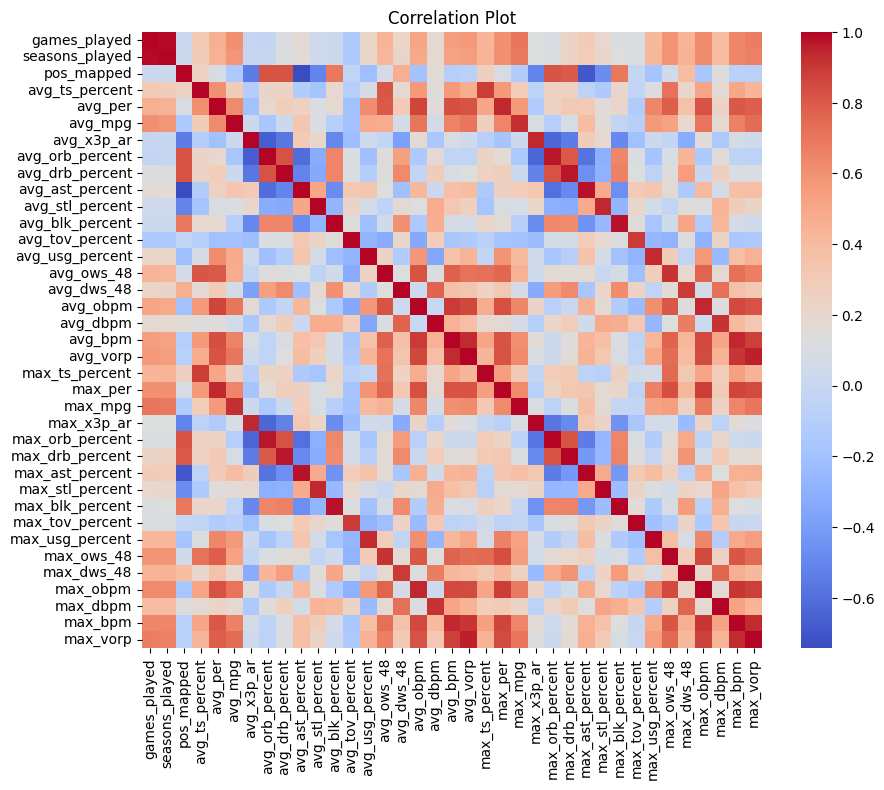

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = pdf_final.iloc[:,2:].corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Plot')
plt.show()

In [13]:
pdf_final.iloc[:,2:].head()

,games_played,seasons_played,pos_mapped,avg_ts_percent,avg_per,avg_mpg,avg_x3p_ar,avg_orb_percent,avg_drb_percent,avg_ast_percent,...,max_stl_percent,max_blk_percent,max_tov_percent,max_usg_percent,max_ows_48,max_dws_48,max_obpm,max_dbpm,max_bpm,max_vorp
0,320,5,1.2,-0.092,-0.252,-0.656,1.152,-0.550,-0.860,0.440,...,2.037,-0.715,0.207,0.234,0.660,-0.155,0.555,0.382,0.263,0.105
1,181,3,5.0,0.652,-1.144,-1.666,-1.097,1.140,0.626,-1.266,...,0.533,4.203,2.501,-1.826,-0.160,1.798,-1.260,2.088,-0.339,-0.563
2,577,8,1.0,0.364,-0.068,0.336,1.360,-1.339,-0.896,1.935,...,0.299,-0.750,2.810,0.526,1.090,-0.548,1.315,-0.637,0.809,0.898
3,617,9,5.0,-0.151,0.096,0.333,-1.078,0.862,1.621,-0.606,...,-0.886,2.775,2.649,1.676,-0.247,1.223,-0.181,1.043,0.248,0.068
4,353,5,1.0,-1.053,-0.466,-1.121,0.571,-0.712,-0.999,2.327,...,1.656,-0.807,2.935,0.501,-0.418,-0.130,0.360,-0.467,-0.234,-0.495
